In [1]:
import os
import math
from tensorflow import keras
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Activation

from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
%config Completer.use_jedi = False

In [10]:
# GPU Configurations

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  0


In [11]:
basedir = "./dataset/" # here below the train and validation data

In [12]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

In [13]:
# Yoga Set 1
yoga_train_path = os.path.join("yoga_set","train") # root for training
yoga_test_path = os.path.join("yoga_set","test") # root for testing

# Yoga Set 2
# yoga_train_path = os.path.join("yoga_set2","train") # root for training
# yoga_test_path = os.path.join("yoga_set2","test") # root for testing

traindir = os.path.join(basedir,yoga_train_path) 
validdir = os.path.join(basedir,yoga_test_path) 

In [14]:

# Yoga Set 1
removeCorruptedImages(os.path.join(traindir,'tree'))
removeCorruptedImages(os.path.join(traindir,'downdog'))
removeCorruptedImages(os.path.join(traindir,'warrior1'))
removeCorruptedImages(os.path.join(traindir,'goddess'))
removeCorruptedImages(os.path.join(traindir,'mountain'))
removeCorruptedImages(os.path.join(traindir,'warrior2'))



removeCorruptedImages(os.path.join(validdir,'tree'))
removeCorruptedImages(os.path.join(validdir,'downdog'))
removeCorruptedImages(os.path.join(validdir,'warrior1'))
removeCorruptedImages(os.path.join(validdir,'goddess'))
removeCorruptedImages(os.path.join(validdir,'mountain'))
removeCorruptedImages(os.path.join(validdir,'warrior2'))

## Image Data Generator

In [15]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [16]:
batch_size=8
print("For Training: ")
train_datagen = train_datagen.flow_from_directory(
                  directory = traindir,
                  target_size=(300,300),
                  batch_size=batch_size,
                  shuffle=True,
                  color_mode="rgb",
                  class_mode='categorical')

print("\nFor Testing: ")
val_datagen = test_datagen.flow_from_directory(
                directory = validdir,
                target_size=(300,300),
                batch_size=batch_size,
                shuffle=False,
                color_mode="rgb",
                class_mode='categorical')

For Training: 
Found 2496 images belonging to 6 classes.

For Testing: 
Found 389 images belonging to 6 classes.


In [18]:
# Loading Pretrained Model

# base_model_path2 = "./pretrained_models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
# base_model =  Xception(weights=base_model_path1, include_top=False, input_shape=(300, 300, 3))

base_model_path1 = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(weights=base_model_path1, include_top=False, input_shape=(300, 300, 3))

In [19]:
output_neurons = 6

model = Sequential()
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(output_neurons))
model.add(Activation('softmax'))


model = Model(inputs=base_model.input, outputs=model(base_model.output))


optimizers = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
losss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(loss=losss,
             optimizer=optimizers,
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [20]:
# Callbacks

class ConvolutionCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>=0.97 and logs.get('val_accuracy') >=0.92):
                print("Reached greater than 97.0% accuracy so cancelling training!")
                self.model.stop_training = True
                
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint("./checkpoints_models/pose_classification_model_weights2.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

convolutionCallback = ConvolutionCallback()
callbacks = [PlotLossesKerasTF(), checkpoint,reduce_lr, convolutionCallback]

## Training

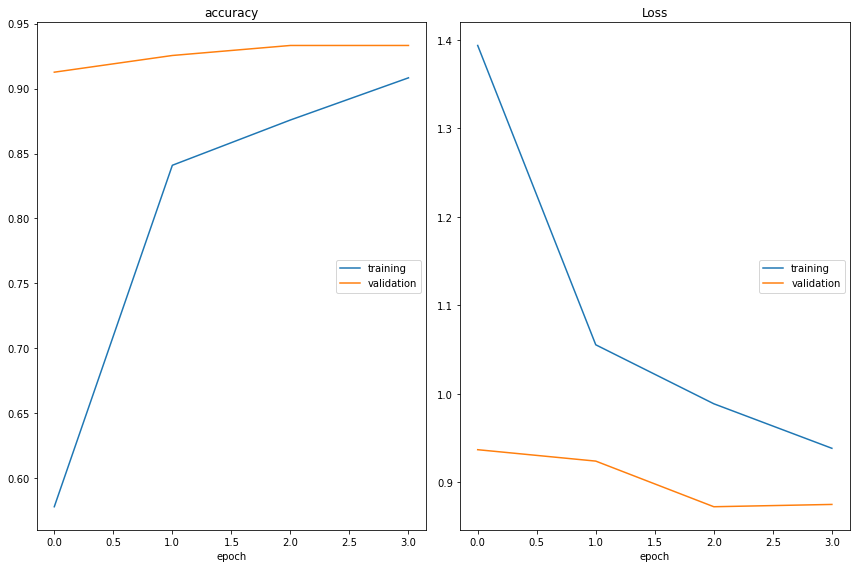

accuracy
	training         	 (min:    0.578, max:    0.908, cur:    0.908)
	validation       	 (min:    0.913, max:    0.933, cur:    0.933)
Loss
	training         	 (min:    0.939, max:    1.394, cur:    0.939)
	validation       	 (min:    0.873, max:    0.937, cur:    0.875)

Epoch 00004: saving model to ./checkpoints_models\pose_classification_model_weights2.h5
312/312 [==============================] - 7209s 23s/step - loss: 0.9386 - accuracy: 0.9083 - val_loss: 0.8752 - val_accuracy: 0.9332 - lr: 1.0000e-04


In [12]:
# epoch_for_model2 = 5
BATCH_SIZE = 16

history = model.fit(train_datagen,
                    epochs=4,
                    validation_data = val_datagen,
                    callbacks=callbacks
                    )

In [ ]:
history = model.fit(train_datagen,
                    epochs=4,
                    validation_data = val_datagen,
                    callbacks=callbacks
                    )

In [2]:
import matplotlib.pyplot as plt
import pickle

In [22]:
from tensorflow.keras.models import load_model
model = load_model('./final_models/H5_Models/Yoga_Set.h5')

In [21]:
plt.figure(0)
plt.plot(history.history['loss'],'g', label="Loss")
plt.plot(history.history['val_loss'],'b',label="Validation Loss")
plt.plot(history.history['accuracy'],'r', label="Accuracy")
plt.plot(history.history['val_accuracy'],'black', label="Validation Accuracy")
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

## Saving Model

In [23]:
yoga_set_model_save_path = "./final_models/H5_Models/Yoga_Set.h5"
# yoga_set2_model_save_path = "./final_models/H5_Models/Yoga_Set2.h5"
model.save(yoga_set_model_save_path)

In [24]:
loaded_model = tf.keras.models.load_model('./final_models/H5_Models/Yoga_Set.h5')
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [25]:
## TFLite Import

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

yoga_final_model_name = "Yoga_Set_TFLite_Model.tflite"
# yoga_final_model_name = "Yoga_Set2_TFLite_Model.tflite"

tflite_model_name = yoga_final_model_name
open(tflite_model_name,"wb").write(tflite_model)

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')
    
convert_bytes(get_file_size(tflite_model_name),"MB")

INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmpl8aweozh\assets


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmpl8aweozh\assets


File size: 76.394 Megabytes


## Testing 

In [26]:
model.evaluate(val_datagen)

D:\softwares__\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


49/49 [==============================] - 193s 4s/step - loss: 0.8752 - accuracy: 0.9332


[0.8751610517501831, 0.9331619739532471]

In [39]:
# yoga_labels = {0:"downdog",1:"tree",2:"warrior1"}
yoga_labels = {0:"downdog",1:"goddess",2:"mountain",3:"tree",4:"warrior1",5:"warrior2"}
# yoga_labels = {0:"goddess",1:"mountain",2:"warrior2"}

Enter Image Name (from 1-21) : 20


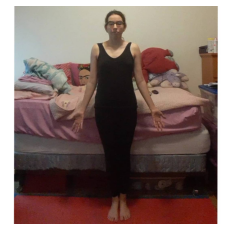

Class Predictions:  [[0.0000000e+00 7.6378165e-37 1.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]]

Prediction is:  mountain


In [53]:
import numpy as np
from keras.preprocessing import image
import matplotlib.image as mpimg

# predicting images
path = input("Enter Image Name (from 1-21) : ")
path = "./dataset/final_test/yoga_set/" + path + ".jpg"

img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
# print(x/255)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = loaded_model.predict(images, batch_size=10)

plt.axis("Off")
img = mpimg.imread(path)
plt.imshow(img)
plt.show()

print("Class Predictions: ",classes)
pred_index = np.argmax(classes[0])
print("\nPrediction is: ", yoga_labels[pred_index])